# Multiple clustering

In this notebook, I'll do **KMeans clustering** over 3 datasets (combined together): **Malaria deaths** and **GDP** across years 2000 to 2012.

## Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MeanShift, Birch, AgglomerativeClustering

import descartes
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load datasets

We'll load two datasets to start.

### Import Malaria deaths

The first dataset is the count of malaria deaths across years for certain countries.

In [2]:
malaria_deaths = pd.read_csv("../data/Countries_with_malaria_deaths.csv")
malaria_deaths.head()

,Country,CountryCode,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,Latitude,Longitude
0,Angola,AGO,9510,9473,14434,38598,12459,13768,10220,9812,9465,10530,8114,6909,5736,-11.202692,17.873887
1,Argentina,ARG,0,0,0,1,0,0,0,0,0,0,0,0,0,-38.416097,-63.616672
2,Azerbaijan,AZE,0,0,0,0,0,0,0,0,0,0,0,0,0,40.143105,47.576927
3,Bangladesh,BGD,484,470,598,574,505,501,508,228,154,47,37,36,11,23.684994,90.356331
4,Bhutan,BTN,15,14,11,14,7,5,7,2,2,4,2,1,1,27.514162,90.433601


### Import GDP

Next, I'll import the GDP values for several countries. As we're only having consistent data for the years 2000 to 2012, I'll filter this dataset based on that.

In [3]:
gdp_data = pd.read_csv("../data/gdp/gdp.csv", skiprows=4)
gdp_data = gdp_data[["Country Name", "Country Code", "2000", "2001", "2002", "2003", 
          "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012"]]
gdp_data = gdp_data.dropna()
gdp_data.head()

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Aruba,ABW,1.873453e+09,1.920112e+09,1.941341e+09,2.021229e+09,2.228492e+09,2.330726e+09,2.424581e+09,2.615084e+09,2.745251e+09,2.498883e+09,2.390503e+09,2.549721e+09,2.534637e+09
2,Angola,AGO,9.129595e+09,8.936064e+09,1.528559e+10,1.781271e+10,2.355205e+10,3.697092e+10,5.238101e+10,6.526645e+10,8.853861e+10,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11
3,Albania,ALB,3.480355e+09,3.922099e+09,4.348070e+09,5.611492e+09,7.184681e+09,8.052076e+09,8.896074e+09,1.067732e+10,1.288135e+10,1.204422e+10,1.192693e+10,1.289077e+10,1.231983e+10
4,Andorra,AND,1.429049e+09,1.546926e+09,1.755910e+09,2.361727e+09,2.894922e+09,3.159905e+09,3.456442e+09,3.952601e+09,4.085631e+09,3.674410e+09,3.449967e+09,3.629204e+09,3.188809e+09
5,Arab World,ARB,7.358105e+11,7.240403e+11,7.297961e+11,8.239927e+11,9.650495e+11,1.186105e+12,1.405832e+12,1.639412e+12,2.079914e+12,1.794336e+12,2.106021e+12,2.494062e+12,2.772882e+12


## Combine datasets

I'll combine the two datasets so I have data for countries together in one dataframe. I'll do an **inner** merge to ensure that we keep countries that are common in both the datasets.

In [4]:
all_data = malaria_deaths.merge(gdp_data, how = 'inner', left_on = 'CountryCode', right_on = 'Country Code')
all_data.head()

,Country,CountryCode,2000_x,2001_x,2002_x,2003_x,2004_x,2005_x,2006_x,2007_x,...,2003_y,2004_y,2005_y,2006_y,2007_y,2008_y,2009_y,2010_y,2011_y,2012_y
0,Angola,AGO,9510,9473,14434,38598,12459,13768,10220,9812,...,1.781271e+10,2.355205e+10,3.697092e+10,5.238101e+10,6.526645e+10,8.853861e+10,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11
1,Argentina,ARG,0,0,0,1,0,0,0,0,...,1.275870e+11,1.646579e+11,1.987371e+11,2.325573e+11,2.875305e+11,3.615580e+11,3.329765e+11,4.236274e+11,5.301633e+11,5.459824e+11
2,Azerbaijan,AZE,0,0,0,0,0,0,0,0,...,7.276013e+09,8.680370e+09,1.324572e+10,2.098299e+10,3.305034e+10,4.885248e+10,4.429149e+10,5.290270e+10,6.595163e+10,6.968394e+10
3,Bangladesh,BGD,484,470,598,574,505,501,508,228,...,6.015893e+10,6.510854e+10,6.944294e+10,7.181908e+10,7.961189e+10,9.163128e+10,1.024778e+11,1.152791e+11,1.286379e+11,1.333557e+11
4,Bhutan,BTN,15,14,11,14,7,5,7,2,...,6.040420e+08,6.825239e+08,7.969381e+08,8.749899e+08,1.168309e+09,1.227809e+09,1.234014e+09,1.547991e+09,1.777101e+09,1.781281e+09


I'll also want to identify the mean malaria deaths and GDP values for all these countries. I'll use this to identify the colors for various colors later.

In [5]:
all_data["Mean_Deaths"] = all_data.iloc[:, 2:15].mean(axis = 1)
all_data["Mean_GDP"] = all_data.iloc[:, 19:].mean(axis = 1)

I'll rename columns, remove redundant columns and create a cleaner version of the dataset.

In [6]:
all_data.columns = ['Country', 'CountryCode', 
                    'malaria_deaths_2000', 'malaria_deaths_2001', 
                    'malaria_deaths_2002', 'malaria_deaths_2003', 
                    'malaria_deaths_2004', 'malaria_deaths_2005', 
                    'malaria_deaths_2006', 'malaria_deaths_2007', 
                    'malaria_deaths_2008', 'malaria_deaths_2009', 
                    'malaria_deaths_2010', 'malaria_deaths_2011', 
                    'malaria_deaths_2012', 
                    'Latitude', 'Longitude', 'Country Name', 'Country Code', 
                    'gdp_2000', 'gdp_2001', 'gdp_2002', 'gdp_2003', 'gdp_2004',
                    'gdp_2005', 'gdp_2006', 'gdp_2007', 'gdp_2008', 'gdp_2009', 
                    'gdp_2010', 'gdp_2011', 'gdp_2012', 
                    'MeanMalariaDeaths', 'MeanGDP']
all_data = all_data.drop(["Country Name", "Country Code"], axis = 1)
all_data = all_data[np.concatenate([["Country", "CountryCode", "Latitude", "Longitude", "MeanMalariaDeaths", "MeanGDP"], 
                all_data.columns[2:15], all_data.columns[17:-2]])]
all_data.head()

,Country,CountryCode,Latitude,Longitude,MeanMalariaDeaths,MeanGDP,malaria_deaths_2000,malaria_deaths_2001,malaria_deaths_2002,malaria_deaths_2003,...,gdp_2003,gdp_2004,gdp_2005,gdp_2006,gdp_2007,gdp_2008,gdp_2009,gdp_2010,gdp_2011,gdp_2012
0,Angola,AGO,-11.202692,17.873887,12232.923077,5.084444e+10,9510,9473,14434,38598,...,1.781271e+10,2.355205e+10,3.697092e+10,5.238101e+10,6.526645e+10,8.853861e+10,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11
1,Argentina,ARG,-38.416097,-63.616672,0.076923,2.754287e+11,0,0,0,1,...,1.275870e+11,1.646579e+11,1.987371e+11,2.325573e+11,2.875305e+11,3.615580e+11,3.329765e+11,4.236274e+11,5.301633e+11,5.459824e+11
2,Azerbaijan,AZE,40.143105,47.576927,0.000000,2.729528e+10,0,0,0,0,...,7.276013e+09,8.680370e+09,1.324572e+10,2.098299e+10,3.305034e+10,4.885248e+10,4.429149e+10,5.290270e+10,6.595163e+10,6.968394e+10
3,Bangladesh,BGD,23.684994,90.356331,319.461538,7.711488e+10,484,470,598,574,...,6.015893e+10,6.510854e+10,6.944294e+10,7.181908e+10,7.961189e+10,9.163128e+10,1.024778e+11,1.152791e+11,1.286379e+11,1.333557e+11
4,Bhutan,BTN,27.514162,90.433601,6.538462,9.358398e+08,15,14,11,14,...,6.040420e+08,6.825239e+08,7.969381e+08,8.749899e+08,1.168309e+09,1.227809e+09,1.234014e+09,1.547991e+09,1.777101e+09,1.781281e+09


## Apply KMeans

The dataset is ready to be used for analysis and plotting. I'll create the inertia plots for malaria deaths and GDP and identify a common elbow for the two plots using the elbow plots.

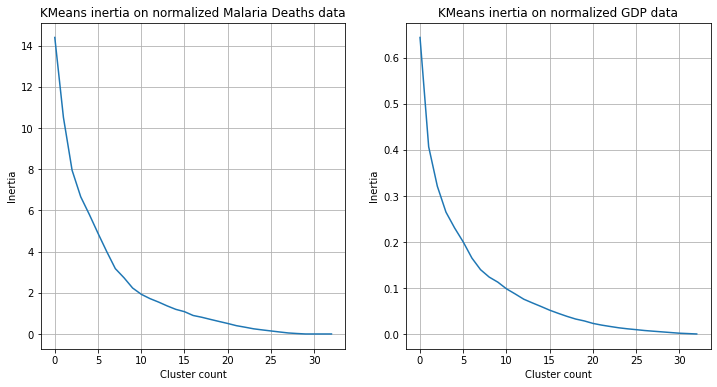

In [7]:
malaria_deaths_inertia = []
gdp_inertia = []

for cluster_count in range(1, all_data.shape[0]):
    
    kmeans = KMeans(cluster_count, init = 'k-means++', random_state = 42)
    kmeans.fit(normalize(all_data.iloc[:, 6:19]))
    malaria_deaths_inertia.append(kmeans.inertia_)
    
    kmeans = KMeans(cluster_count, init = 'k-means++', random_state = 42)
    kmeans.fit(normalize(all_data.iloc[:, 19:]))
    gdp_inertia.append(kmeans.inertia_)
    
plt.figure(figsize = (12, 6))

ax = plt.subplot(121)
ax.plot(malaria_deaths_inertia, label = 'Malaria Deaths')
ax.set_xlabel("Cluster count")
ax.set_ylabel("Inertia")
ax.set_title("KMeans inertia on normalized Malaria Deaths data")
ax.grid(True)

ax2 = plt.subplot(122)
ax2.plot(gdp_inertia, label = 'GDP')
ax2.set_xlabel("Cluster count")
ax2.set_ylabel("Inertia")
ax2.set_title("KMeans inertia on normalized GDP data")
ax2.grid(True)

Looks like the best choice of **k** would be 6.

### Running KMeans

We now run the KMeans algorithm on the data to create clusters for both malaria deaths and GDP.

In [8]:
map_data = all_data.copy()

kmeans = KMeans(6, init = 'k-means++', random_state = 42)
kmeans.fit(normalize(map_data.iloc[:, 6:19]))
map_data['ClusterForMalariaDeaths'] = kmeans.labels_
map_data['ClusterForMalariaDeaths'] = map_data['ClusterForMalariaDeaths'].astype('category')

kmeans = KMeans(6, init = 'k-means++', random_state = 42)
kmeans.fit(normalize(map_data.iloc[:, 19:-1])) # Ignoring last column which is the column we added above
map_data['ClusterForGDP'] = kmeans.labels_
map_data['ClusterForGDP'] = map_data['ClusterForGDP'].astype('category')

map_data.head()

,Country,CountryCode,Latitude,Longitude,MeanMalariaDeaths,MeanGDP,malaria_deaths_2000,malaria_deaths_2001,malaria_deaths_2002,malaria_deaths_2003,...,gdp_2005,gdp_2006,gdp_2007,gdp_2008,gdp_2009,gdp_2010,gdp_2011,gdp_2012,ClusterForMalariaDeaths,ClusterForGDP
0,Angola,AGO,-11.202692,17.873887,12232.923077,5.084444e+10,9510,9473,14434,38598,...,3.697092e+10,5.238101e+10,6.526645e+10,8.853861e+10,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11,5,4
1,Argentina,ARG,-38.416097,-63.616672,0.076923,2.754287e+11,0,0,0,1,...,1.987371e+11,2.325573e+11,2.875305e+11,3.615580e+11,3.329765e+11,4.236274e+11,5.301633e+11,5.459824e+11,5,5
2,Azerbaijan,AZE,40.143105,47.576927,0.000000,2.729528e+10,0,0,0,0,...,1.324572e+10,2.098299e+10,3.305034e+10,4.885248e+10,4.429149e+10,5.290270e+10,6.595163e+10,6.968394e+10,1,4
3,Bangladesh,BGD,23.684994,90.356331,319.461538,7.711488e+10,484,470,598,574,...,6.944294e+10,7.181908e+10,7.961189e+10,9.163128e+10,1.024778e+11,1.152791e+11,1.286379e+11,1.333557e+11,4,3
4,Bhutan,BTN,27.514162,90.433601,6.538462,9.358398e+08,15,14,11,14,...,7.969381e+08,8.749899e+08,1.168309e+09,1.227809e+09,1.234014e+09,1.547991e+09,1.777101e+09,1.781281e+09,0,0


I can now drop a lot of the columsn we would no longer need and keep only the essential ones. I'll also move the latitude and longitude to the end, just for aesthetics.

In [9]:
map_data = map_data[["Country", "CountryCode", "MeanMalariaDeaths", "MeanGDP", 
                     "ClusterForMalariaDeaths", "ClusterForGDP", "Latitude", "Longitude"]]
map_data.head()

,Country,CountryCode,MeanMalariaDeaths,MeanGDP,ClusterForMalariaDeaths,ClusterForGDP,Latitude,Longitude
0,Angola,AGO,12232.923077,5.084444e+10,5,4,-11.202692,17.873887
1,Argentina,ARG,0.076923,2.754287e+11,5,5,-38.416097,-63.616672
2,Azerbaijan,AZE,0.000000,2.729528e+10,1,4,40.143105,47.576927
3,Bangladesh,BGD,319.461538,7.711488e+10,4,3,23.684994,90.356331
4,Bhutan,BTN,6.538462,9.358398e+08,0,0,27.514162,90.433601


## Create geographic data

Using the dataset we just created and the geopandas package, I'll create a dataset that has the location polygons for each country built into it. This will facilitate plotting of data. I'll do a **left** merge here so we have the complete map and can fill in data wherever it is available while ensuring the remaining countries also show up (even though blank).

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(map_data, how = 'left', left_on = 'iso_a3', right_on = 'CountryCode')

## Generate plots

I'll first identify the mean values of malaria deaths and GDP for each cluster and set colors for clusters accordingly. The darker the color, higher the mean value. Next, I'll plot the data on a map.

### Means for each cluster

I'll calculate the average malaria deaths and GDP for each cluster.

In [11]:
# For Malaria Deaths
grouped_malaria_deaths = world.dropna()[["MeanMalariaDeaths", "ClusterForMalariaDeaths"]]
grouped_malaria_deaths = grouped_malaria_deaths.groupby(['ClusterForMalariaDeaths']).mean().reset_index()
grouped_malaria_deaths

,ClusterForMalariaDeaths,MeanMalariaDeaths
0,0,117.423077
1,1,0.021978
2,2,4812.263736
3,3,0.076923
4,4,464.509615
5,5,2453.400000


In [12]:
# For GDP
grouped_gdp = world.dropna()[["MeanGDP", "ClusterForGDP"]]
grouped_gdp = grouped_gdp.groupby(['ClusterForGDP']).mean().reset_index()
grouped_gdp['MeanGDP'] = grouped_gdp['MeanGDP'].apply(lambda x: '{:.2f}'.format(x))
grouped_gdp

,ClusterForGDP,MeanGDP
0,0,28133399525.76
1,1,179603662165.63
2,2,418235747368.07
3,3,68249925132.69
4,4,32146298159.88
5,5,145314045156.99


Based on the mean values above, I'll assign the colors for each cluster. The smallest mean will have the lightest color and the largest mean will have the darkest color.

### Set color

I'll now set the colors for the plotting.

In [13]:
# Color for Malaria Deaths
world['ColorForMalariaDeaths'] = world['ClusterForMalariaDeaths']

# Set default color as White
world['ColorForMalariaDeaths'] = '#fff'

# Set colors accoring to Mean Malaria Deaths per cluster
world.loc[world['ClusterForMalariaDeaths'] == 0, 'ColorForMalariaDeaths'] = '#ff4c4c'
world.loc[world['ClusterForMalariaDeaths'] == 1, 'ColorForMalariaDeaths'] = '#ffcccc'
world.loc[world['ClusterForMalariaDeaths'] == 2, 'ColorForMalariaDeaths'] = '#000000'
world.loc[world['ClusterForMalariaDeaths'] == 3, 'ColorForMalariaDeaths'] = '#ff9999'
world.loc[world['ClusterForMalariaDeaths'] == 4, 'ColorForMalariaDeaths'] = '#ff0000'
world.loc[world['ClusterForMalariaDeaths'] == 5, 'ColorForMalariaDeaths'] = '#7f0000'

In [14]:
# Color for GDP
world['ColorForGDP'] = world['ClusterForGDP']

# Set default color as White
world['ColorForGDP'] = '#fff'

# Set colors accoring to MGDP per cluster
world.loc[world['ClusterForGDP'] == 0, 'ColorForGDP'] = '#ccccff'
world.loc[world['ClusterForGDP'] == 1, 'ColorForGDP'] = '#00007f'
world.loc[world['ClusterForGDP'] == 2, 'ColorForGDP'] = '#000000'
world.loc[world['ClusterForGDP'] == 3, 'ColorForGDP'] = '#3232ff'
world.loc[world['ClusterForGDP'] == 4, 'ColorForGDP'] = '#7f7fff'
world.loc[world['ClusterForGDP'] == 5, 'ColorForGDP'] = '#0000ff'

### Malaria Deaths plot

Below is the geo-plot for Malaria Deaths across years 2000-2012 for 35 countries.

(-60.0, 50.0)

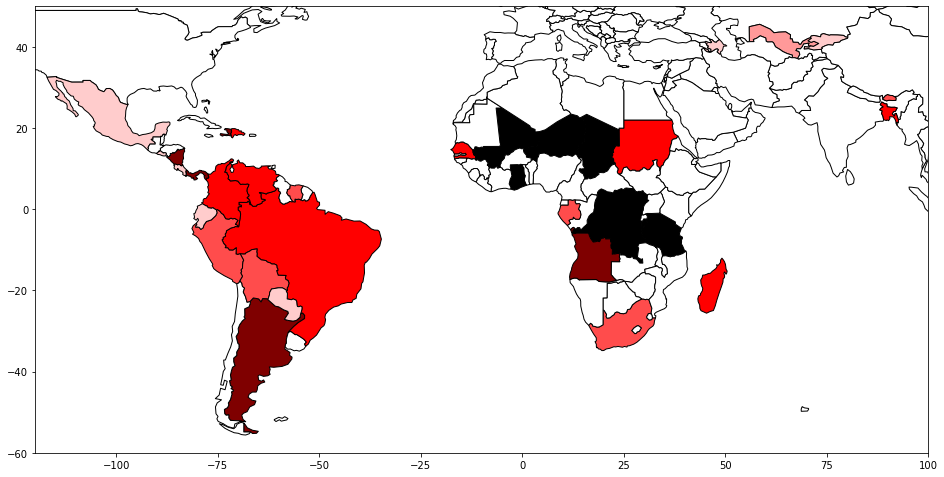

In [15]:
world.plot(column = 'ClusterForMalariaDeaths',
           color = world['ColorForMalariaDeaths'], 
           edgecolor = 'black',
           figsize = (16, 16))
plt.xlim([-120, 100])
plt.ylim([-60, 50])

### GDP plot

Below is the geo-plot for GDP across years 2000-2012 for 35 countries.

(-60.0, 50.0)

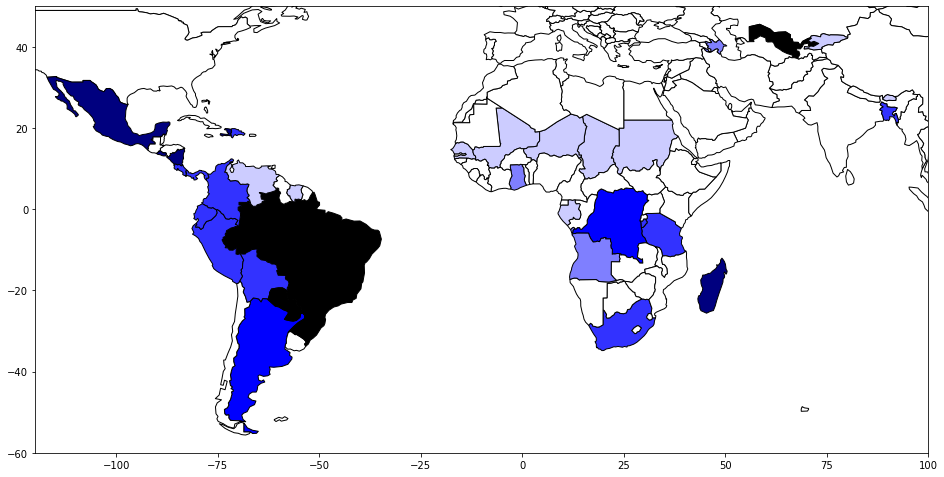

In [16]:
world.plot(column = 'ClusterForGDP',
           color = world['ColorForGDP'], 
           edgecolor = 'black',
           figsize = (16, 16))
plt.xlim([-120, 100])
plt.ylim([-60, 50])